# Classification problem

The task is to predict if a sales opportunity will result in a won or a lost contract.

In [2]:
# setting logging to print only error messages of sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# dumping models to files
import os
from joblib import dump

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# Load the data

In [4]:
url = "https://raw.githubusercontent.com/vkrit/data-science-class/master/WA_Fn-UseC_-Sales-Win-Loss.csv"
df = pd.read_csv(url)

In [5]:
df.head()

,Opportunity Number,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
0,1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.69636,0.113985,0.154215,1
1,1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.00000,1.000000,0.000000,1
2,1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.00000,0.000000,0.000000,1
3,1675224,Shelters & RV,Performance & Non-auto,Midwest,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.00000,0.000000,0.000000,1
4,1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.00000,0.141125,0.000000,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78025 entries, 0 to 78024
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Opportunity Number                       78025 non-null  int64  
 1   Supplies Subgroup                        78025 non-null  object 
 2   Supplies Group                           78025 non-null  object 
 3   Region                                   78025 non-null  object 
 4   Route To Market                          78025 non-null  object 
 5   Elapsed Days In Sales Stage              78025 non-null  int64  
 6   Opportunity Result                       78025 non-null  object 
 7   Sales Stage Change Count                 78025 non-null  int64  
 8   Total Days Identified Through Closing    78025 non-null  int64  
 9   Total Days Identified Through Qualified  78025 non-null  int64  
 10  Opportunity Amount USD                   78025

# Train-test split

In [8]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df, test_size=0.2,
                                     stratify=df["Opportunity Result"], random_state=7)

In [9]:
trainset["Opportunity Result"].value_counts(normalize=True)

Loss    0.774079
Won     0.225921
Name: Opportunity Result, dtype: float64

In [10]:
testset["Opportunity Result"].value_counts(normalize=True)

Loss    0.774111
Won     0.225889
Name: Opportunity Result, dtype: float64

In [11]:
print(f"There are {trainset.shape[0]} training and {testset.shape[0]} test instances")

There are 62420 training and 15605 test instances


# Step 3. Exploratory Data Analysis

## Distribution of numerical variables

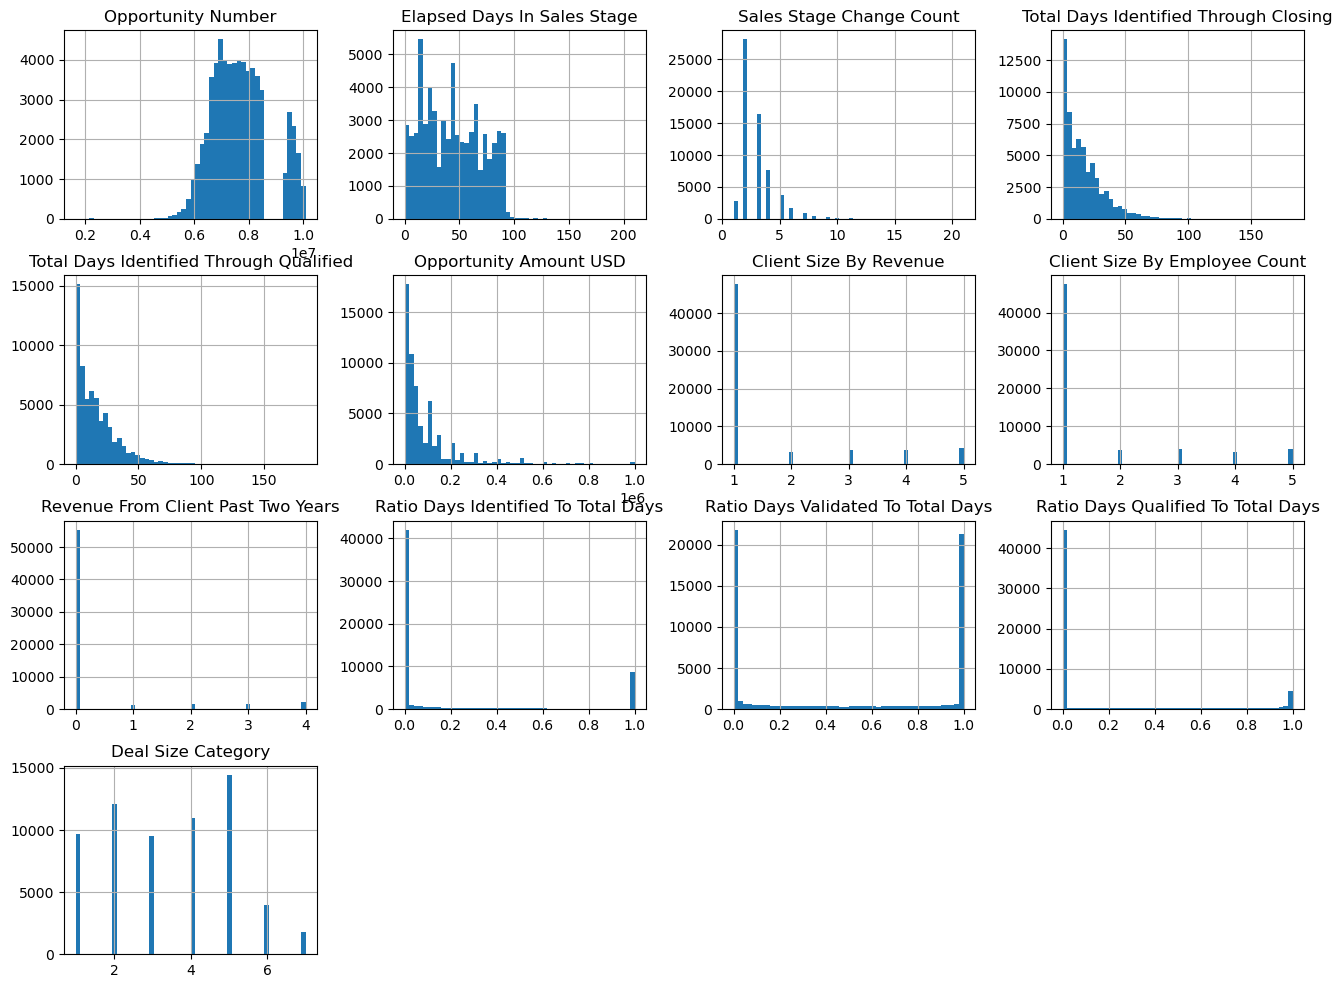

In [13]:
dummy = trainset.hist(bins=50, figsize=(16,12))

In [14]:
trainset[trainset["Opportunity Amount USD"] == 0].shape[0]

1641

In [15]:
trainset[(trainset["Opportunity Amount USD"] == 0) & (trainset["Deal Size Category"] == 1)].shape[0]

1641

## Distribution of categorical variables

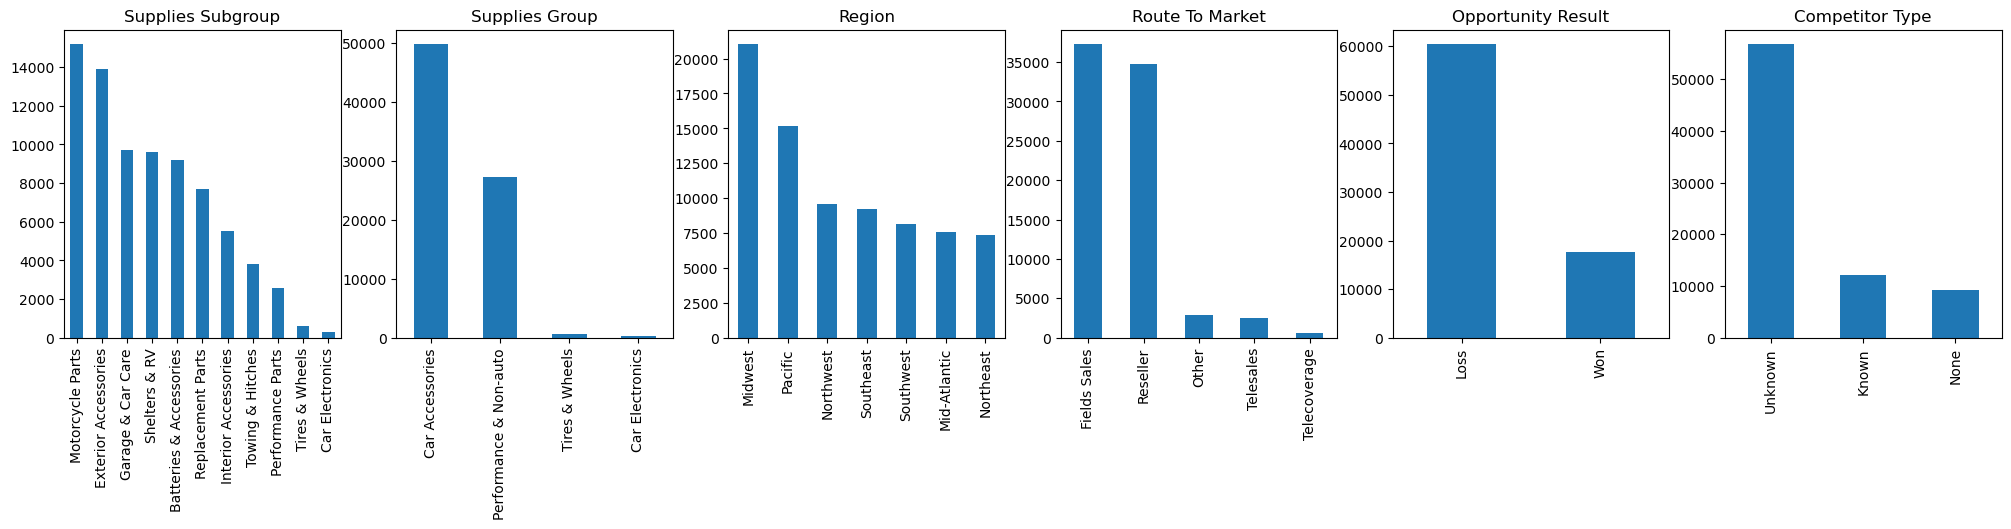

In [17]:
categorical_features = df.select_dtypes(include=['object']).columns

fig, ax = plt.subplots(1, len(categorical_features), figsize=(25, 4))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

# Data cleaning and transformation

## Delete variables

In [19]:
trainset.drop(columns=["Supplies Group", "Opportunity Number"], inplace=True)
testset.drop(columns=["Supplies Group", "Opportunity Number"], inplace=True)

## Log-transform right tail-heavy variables

In [21]:
for x in ["Opportunity Amount USD", "Elapsed Days In Sales Stage", "Sales Stage Change Count",
          "Total Days Identified Through Closing", "Total Days Identified Through Qualified"]:
    # add 1 so that 0s remain 0s
    trainset[x] = np.log(trainset[x] + 1)
    testset[x] = np.log(testset[x] + 1)

## Create dummies

In [23]:
from sklearn.preprocessing import OneHotEncoder


one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)

# categorical columns to transform
cat_cols = ["Supplies Subgroup", "Region", "Route To Market", "Competitor Type"]

# fit an encoder and transform the **trainset**
cat_vals = trainset[cat_cols].to_numpy()
transformed = one_hot_encoder.fit_transform(cat_vals)

# the names of the new columns are the unique values of the categorical variables
new_col_names = one_hot_encoder.get_feature_names_out(cat_cols)

# put the transformed data as columns in the trainset dataframe
for i, new_col_name in enumerate(new_col_names):
    trainset[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the trainset
trainset.head()

,Supplies Subgroup,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,...,Region_Northwest,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_None,Competitor Type_Unknown
8279,Shelters & RV,Pacific,Fields Sales,4.262680,Loss,1.609438,3.258097,3.258097,11.542494,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16176,Shelters & RV,Northwest,Fields Sales,2.833213,Loss,1.791759,4.143135,4.143135,11.918397,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63195,Garage & Car Care,Northeast,Reseller,3.912023,Won,1.386294,2.197225,2.197225,9.014447,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12810,Motorcycle Parts,Pacific,Fields Sales,4.343805,Loss,1.098612,2.302585,2.302585,11.561725,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54035,Shelters & RV,Mid-Atlantic,Fields Sales,4.454347,Loss,1.098612,1.098612,1.098612,11.695255,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
# transform the **testset** using the encoder fitted on trainset
cat_vals = testset[cat_cols].to_numpy()
transformed = one_hot_encoder.transform(cat_vals)

# put the transformed data as columns in the testset dataframe
for i, new_col_name in enumerate(new_col_names):
    testset[new_col_name] = transformed[:,i]
    
# check if the dummies are produced correctly in the testset
testset.head()

,Supplies Subgroup,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,...,Region_Northwest,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_None,Competitor Type_Unknown
60315,Batteries & Accessories,Southeast,Fields Sales,3.828641,Loss,1.609438,3.091042,3.091042,11.824014,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10342,Shelters & RV,Midwest,Fields Sales,4.356709,Loss,1.098612,2.639057,2.639057,11.695255,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37888,Batteries & Accessories,Midwest,Other,3.401197,Loss,1.098612,0.693147,0.693147,11.918397,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2755,Performance Parts,Pacific,Reseller,4.510860,Loss,1.098612,3.295837,3.295837,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
53636,Exterior Accessories,Southeast,Fields Sales,4.343805,Loss,1.386294,2.564949,2.564949,12.456835,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
trainset.drop(columns=cat_cols, inplace=True)
testset.drop(columns=cat_cols, inplace=True)

## Scale features

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# take the target variable out before scaling
trainset_target = trainset["Opportunity Result"].values
trainset_predictors = trainset.drop("Opportunity Result", axis=1)

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(trainset_predictors)
trainset = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# put the non-scaled target back in
trainset['Opportunity Result'] = trainset_target

# inspect the data
trainset.head()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_None,Competitor Type_Unknown,Opportunity Result
0,0.834715,0.909889,0.778476,0.799311,0.535819,1.112712,-0.499072,-0.325506,0.335908,-0.830850,...,2.038657,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss
1,-0.767406,1.482327,1.532528,1.534874,0.699966,2.727300,1.983626,-0.325506,-0.418460,1.029264,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss
2,0.441705,0.209282,-0.125386,-0.082389,-0.568110,-0.501875,-0.499072,0.750549,-0.555992,-1.061819,...,-0.490519,-0.365922,-0.339735,-0.194132,1.113772,-0.089679,-0.180949,-0.366934,0.613297,Won
3,0.925639,-0.693958,-0.035619,0.005177,0.544217,1.112712,-0.499072,-0.325506,-0.555992,1.141228,...,2.038657,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,0.613297,Loss
4,1.049532,-0.693958,-1.061403,-0.995456,0.602526,-0.501875,-0.499072,-0.325506,2.185778,-1.090806,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,0.613297,Loss


In [28]:
testset_target = testset["Opportunity Result"].values
testset_predictors = testset.drop("Opportunity Result", axis=1)

scaled_vals = scaler.transform(testset_predictors)
testset = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# put the non-scaled target back in
testset['Opportunity Result'] = testset_target

testset.head()

,Elapsed Days In Sales Stage,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,...,Region_Pacific,Region_Southeast,Region_Southwest,Route To Market_Other,Route To Market_Reseller,Route To Market_Telecoverage,Route To Market_Telesales,Competitor Type_None,Competitor Type_Unknown,Opportunity Result
0,0.348252,0.909889,0.636146,0.660471,0.658752,1.112712,1.983626,-0.325506,-0.305543,-0.865456,...,-0.490519,2.732823,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss
1,0.940101,-0.693958,0.251055,0.284822,0.602526,1.920006,-0.499072,-0.325506,-0.555992,1.141228,...,-0.490519,-0.365922,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,2.725282,-1.630533,Loss
2,-0.130819,-0.693958,-1.406859,-1.332442,0.699966,-0.501875,-0.499072,-0.325506,2.185778,-1.090806,...,-0.490519,-0.365922,-0.339735,5.151134,-0.897850,-0.089679,-0.180949,-0.366934,0.613297,Loss
3,1.112870,-0.693958,0.810631,0.830677,-4.504476,-0.501875,1.983626,-0.325506,-0.555992,1.141228,...,2.038657,-0.365922,-0.339735,-0.194132,1.113772,-0.089679,-0.180949,-0.366934,0.613297,Loss
4,0.925639,0.209282,0.187915,0.223230,0.935087,-0.501875,-0.499072,-0.325506,-0.293737,-1.090806,...,-0.490519,2.732823,-0.339735,-0.194132,-0.897850,-0.089679,-0.180949,-0.366934,-1.630533,Loss


# Model development

In [30]:
from sklearn.model_selection import GridSearchCV

Xtrain = trainset.drop("Opportunity Result", axis=1)
ytrain = trainset["Opportunity Result"].copy()
Xtest = testset.drop("Opportunity Result", axis=1)
ytest = testset["Opportunity Result"].copy()

## Baseline

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat = dummy_clf.predict(Xtrain)

p, r, f, s = precision_recall_fscore_support(ytrain, yhat, average="macro", zero_division=0.0)
print("Baseline:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")

Baseline:
Precision: 0.387
Recall: 0.500
F score: 0.436


## Decision Tree

In [23]:
start = timer()

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=7)

hp_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35],
}

grid_search = GridSearchCV(dt, hp_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True, verbose=2)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.2s
[CV] END ..................max_depth=5, min_sam

In [24]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=35, random_state=7)

In [25]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
13,"{'max_depth': 10, 'min_samples_split': 35}",0.820297,0.794796,3.108720
12,"{'max_depth': 10, 'min_samples_split': 30}",0.820906,0.794733,3.188244
11,"{'max_depth': 10, 'min_samples_split': 25}",0.821810,0.794510,3.321954
7,"{'max_depth': 10, 'min_samples_split': 5}",0.828046,0.794268,4.079183
8,"{'max_depth': 10, 'min_samples_split': 10}",0.826299,0.794241,3.879698
10,"{'max_depth': 10, 'min_samples_split': 20}",0.823155,0.794115,3.527915
9,"{'max_depth': 10, 'min_samples_split': 15}",0.824527,0.793828,3.723263
20,"{'max_depth': 15, 'min_samples_split': 35}",0.855696,0.791777,7.469873
19,"{'max_depth': 15, 'min_samples_split': 30}",0.859795,0.791068,7.993341
18,"{'max_depth': 15, 'min_samples_split': 25}",0.864312,0.789465,8.659730


## Random Forest

In [26]:
start = timer()

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7, max_depth=40, min_samples_split=5)

# specify the hyperparameters and their values
# 3 x 2 x 2 = 12 combinations in the grid
hp_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ["sqrt", 0.5],
    'max_samples': [None, 0.5],
}

grid_search = GridSearchCV(rf, hp_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True, verbose=2)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   6.3s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   6.3s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   6.3s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   6.4s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   6.3s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  12.8s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  13.3s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  13.1s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  13.3s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  12.7s
[CV] END max_features=sqrt, max_samples=None, n_estimators=500; total time=  32.4s
[CV] END max_features=sqrt

In [27]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=40, max_features=0.5, min_samples_split=5,
                       n_estimators=500, random_state=7)

In [28]:
grid_search.best_score_

0.8238490863403711

In [31]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
8,"{'max_features': 0.5, 'max_samples': None, 'n_estimators': 500}",0.984642,0.823849,16.330110
6,"{'max_features': 0.5, 'max_samples': None, 'n_estimators': 100}",0.983464,0.823412,16.274329
7,"{'max_features': 0.5, 'max_samples': None, 'n_estimators': 200}",0.984176,0.823346,16.341547
11,"{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 500}",0.931119,0.823154,11.595170
10,"{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}",0.930752,0.823099,11.566228
9,"{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}",0.929504,0.820908,11.683224
2,"{'max_features': 'sqrt', 'max_samples': None, 'n_estimators': 500}",0.973386,0.819100,15.850462
1,"{'max_features': 'sqrt', 'max_samples': None, 'n_estimators': 200}",0.973245,0.818551,15.894693
0,"{'max_features': 'sqrt', 'max_samples': None, 'n_estimators': 100}",0.972229,0.817442,15.920843
4,"{'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 200}",0.920367,0.816447,11.291094


In [32]:
feature_importances = grid_search.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k:.3f}")

Opportunity Amount USD: 0.126
Revenue From Client Past Two Years: 0.123
Elapsed Days In Sales Stage: 0.122
Total Days Identified Through Qualified: 0.121
Sales Stage Change Count: 0.075
Ratio Days Qualified To Total Days: 0.073
Total Days Identified Through Closing: 0.071
Ratio Days Validated To Total Days: 0.043
Ratio Days Identified To Total Days: 0.033
Route To Market_Reseller: 0.032
Deal Size Category: 0.026
Client Size By Employee Count: 0.014
Client Size By Revenue: 0.013
Supplies Subgroup_Motorcycle Parts: 0.010
Region_Pacific: 0.010
Region_Midwest: 0.009
Supplies Subgroup_Exterior Accessories: 0.009
Competitor Type_Unknown: 0.009
Region_Northeast: 0.008
Competitor Type_nan: 0.008
Supplies Subgroup_Garage & Car Care: 0.008
Region_Northwest: 0.008
Region_Southwest: 0.008
Supplies Subgroup_Replacement Parts: 0.007
Region_Southeast: 0.007
Supplies Subgroup_Shelters & RV: 0.007
Supplies Subgroup_Interior Accessories: 0.005
Supplies Subgroup_Towing & Hitches: 0.004
Route To Market_Te

In [33]:
# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/rf-clf.joblib')

['models/rf-clf.joblib']

## Support Vector Machines

### Linear SVMs

In [34]:
start = timer()

from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=5000)

hp_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
}

grid_search = GridSearchCV(lsvm, hp_grid, cv=5, scoring='f1_macro', 
                           return_train_score=True) 
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\svm\_base.py:1244: Conv

Execution time HH:MM:SS: 0:09:04.360241


In [35]:
grid_search.best_estimator_

LinearSVC(C=0.1, max_iter=5000, random_state=7)

In [36]:
grid_search.best_score_

0.7077948552002802

In [37]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
2,{'C': 0.1},0.709174,0.707795,0.194531
3,{'C': 1},0.709209,0.707706,0.212024
1,{'C': 0.01},0.709007,0.707585,0.200503
4,{'C': 10},0.708831,0.707470,0.191934
0,{'C': 0.001},0.708879,0.707341,0.216977


In [38]:
dump(grid_search.best_estimator_, 'models/svm-linear-clf.joblib')

['models/svm-linear-clf.joblib']

### Radial Basis Function

<span style="color:red;font-weight:bold">Careful - the cell below may take a couple of hours to complete!</span>

In [39]:
start = timer()

from sklearn.svm import SVC

svm = SVC(random_state=7, kernel='rbf')

hp_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(svm, hp_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True, verbose=2) 

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 2:47:22.133550


In [40]:
grid_search.best_estimator_

SVC(C=10, random_state=7)

In [41]:
grid_search.best_score_

0.7925449143530867

In [46]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
3,{'C': 10},0.857182,0.792545,7.540655
4,{'C': 100},0.913898,0.781919,14.441304
2,{'C': 1},0.804041,0.780964,2.870214
1,{'C': 0.1},0.742553,0.735789,0.910839
0,{'C': 0.01},0.576784,0.574238,0.441415


In [47]:
dump(grid_search.best_estimator_, 'models/svm-rbf-clf.joblib')

['models/svm-rbf-clf.joblib']

### Polynomial SVM

<span style="color:red;font-weight:bold">Careful - the cell below may take a couple of hours to complete!</span>

In [60]:
start = timer()

from sklearn.svm import SVC

svm_poly = SVC(kernel="poly", gamma="scale", random_state=7, degree=2)

hp_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(svm_poly, hp_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True, verbose=2)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .............................................C=0.01; total time= 1.7min
[CV] END .............................................C=0.01; total time= 1.7min
[CV] END .............................................C=0.01; total time= 1.7min
[CV] END .............................................C=0.01; total time= 1.7min
[CV] END .............................................C=0.01; total time= 1.7min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ................................................C=1; total time= 1.5min
[CV] END ........................................

In [61]:
grid_search.best_estimator_

SVC(C=100, degree=2, kernel='poly', random_state=7)

In [62]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
4,{'C': 100},0.729854,0.722695,0.980840
3,{'C': 10},0.712771,0.707517,0.737124
2,{'C': 1},0.686466,0.682008,0.649392
1,{'C': 0.1},0.603576,0.600337,0.536575
0,{'C': 0.01},0.504411,0.503638,0.153098


# Evaluate the best models

In [63]:
from joblib import load

best_rf = load("models/rf-clf.joblib")
best_svm = load("models/svm-rbf-clf.joblib")

## Random Forest

In [64]:
# rf
yhat = best_rf.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.8506795147339421
Recall: 0.8133150744446009
F score: 0.8296545994963657


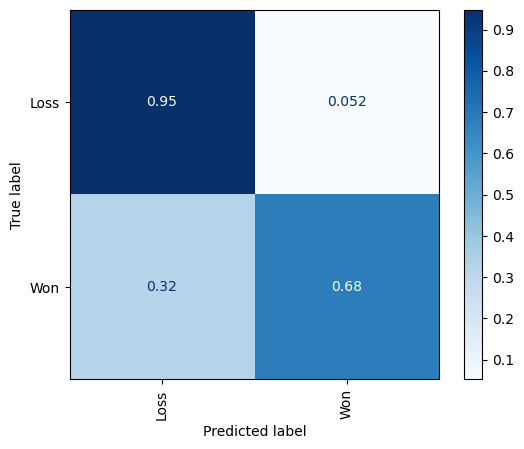

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_rf.classes_, 
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

## SVM

In [66]:
# svm
yhat = best_svm.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("SVM:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

SVM:
Precision: 0.8314108113378981
Recall: 0.7822270560330655
F score: 0.8024669855702284


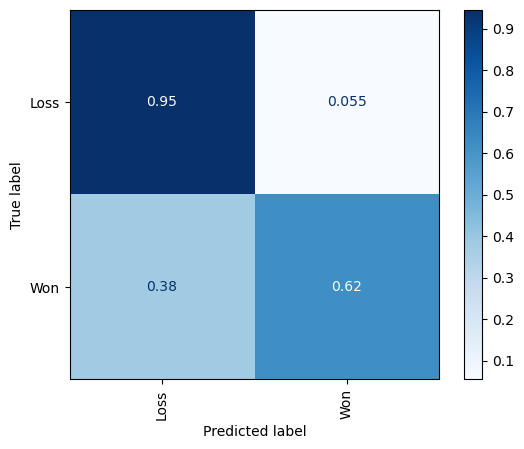

In [67]:
ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
